In [1]:
pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [2]:

import pandas as pd
import numpy as np
from pandasql import sqldf

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf


plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')


import warnings
warnings.filterwarnings('ignore')

LECTURA DE LA CAPA SILVER

In [3]:
df_select = pd.read_csv("C:/Users/varit/Desktop/DATAB/SILVER/Fact_Air_BNB.csv", sep = ';')

COMPROBACION DE LOS NULOS PARA CORROBORAR UNA CORRECTA CARGA DE LOS DATOS

In [4]:
df_select.isnull().sum()

ID                                0
Description                     286
Name                            954
Space                        147836
City                           1685
State                         50815
Country                           2
Bathrooms                      1489
Bedrooms                          0
SquareFeet                   482156
Price                          7954
WeeklyPrice                  396758
MonthlyPrice                 398402
NumberofReviews                   0
ReviewScoresRating           127637
ReviewScoresAccuracy         128531
ReviewScoresCleanliness      128290
ReviewScoresCheckin          128850
ReviewScoresCommunication    128334
ReviewScoresLocation         128799
ReviewScoresValue            128895
CancellationPolicy                0
Geolocation                       0
State_F                        1216
City_F                         1359
dtype: int64

#### SE OBSERVA QUE LOS APARTAMENTOS EN ESPAÑA SIGUEN UNA TENDENCIA MUY LINEAL EN SU PRECIO EN FUNCION DE LAS HABITACIONES QUE POSEEN

FILTRAMOS SPAIN PARA OBTENER SOLO LOS APARTAMENTOS QUE QUEREMOS INTRODUCIR EN EL MODELO

In [5]:
q="""select 
Country,
Bedrooms,
avg(Price) as Price
from df_select
where Country ='SPAIN' and Bedrooms between 1 and 9
group by Country, Bedrooms"""
pysqldf = lambda q: sqldf(q, globals())
df = pysqldf(q)

In [6]:
y=df["Price"].values
x=df["Bedrooms"].values

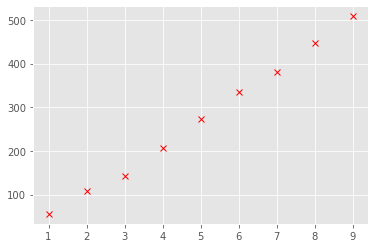

In [7]:
plt.plot(x,y,'x', color='red')

In [8]:
#SEPARANDO POR PAISES

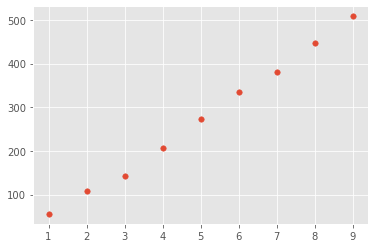

In [9]:
fig, ax = plt.subplots()
for Country in set(df.Country):
    ax.scatter(
        df.Bedrooms[df.Country == Country],
        df.Price[df.Country == Country],
        s = 30,
        label = df.Country)
#plt.legend()
plt.show()

In [10]:
df= df.dropna()

In [11]:
# Correlación lineal entre las dos variables
corr_test = pearsonr(x = df['Price'], y =  df['Bedrooms'])
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  0.9983663214250975
P-value:  5.793355802875385e-10


Existe bastante consenso a la hora de interpretar los valores del coeficiente de correlación de Pearson utilizando los siguientes criterios (y considerando los valores absolutos):

Entre 0 y 0,10: correlación inexistente

Entre 0,10 y 0,29: correlación débil

Entre 0,30 y 0,50: correlación moderada

Entre 0,50 y 1,00: correlación fuerte

In [12]:
# División de los datos en train y test

X = df[['Bedrooms']]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Creación del modelo

modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

LinearRegression()

In [13]:
# Información del modelo

print("Intercept:", modelo.intercept_)
print("Coeficiente:", list(zip(X.columns, modelo.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", modelo.score(X, y))

Intercept: [-5.06392242]
Coeficiente: [('Bedrooms', 55.843274489929)]
Coeficiente de determinación R^2: 0.9960936457713471


In [14]:
predicciones = modelo.predict(X = X_test)
print(predicciones[0:3,])

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")

[[497.52554799]
 [162.46590105]]

El error (rmse) de test es: 16.20434283657056


In [15]:
# División de los datos en train y test

X = df[['Bedrooms']]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [16]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2507.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):           6.01e-08
Time:                        18:35:19   Log-Likelihood:                -22.380
No. Observations:                   7   AIC:                             48.76
Df Residuals:                       5   BIC:                             48.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0639      5.887     -0.860      0.4

# PRECIO=55.8433*HABITACIONES - 5.0639

In [17]:
# Intervalos de confianza para los coeficientes del modelo

modelo.conf_int(alpha=0.05)

array([[-20.19639125,  10.06854642],
       [ 52.97618332,  58.71036565]])

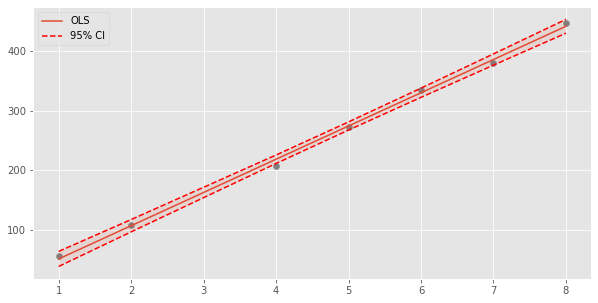

In [18]:
# Predicciones con intervalo de confianza del 95%

predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones['x'] = X_train[:, 1]
predicciones['y'] = y_train
predicciones = predicciones.sort_values('x')

# Gráfico del modelo

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray")
ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="95% CI")
ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.1)
ax.legend();

In [28]:
def prediction(Bedrooms):
    if Bedrooms<1:
        res="Un apartamento no puede tener menos de 1 habitacion"
    else:
        precio=55.8433*Bedrooms -5.0639
        res="EL PRECIO DE UN APARTAMENTO CON", Bedrooms, "HABITACIONES SERÍA DE:", precio, "€"
    return(res)

In [29]:
prediction(1)

('EL PRECIO DE UN APARTAMENTO CON',
 1,
 'HABITACIONES SERÍA DE:',
 50.779399999999995,
 '€')